<a href="https://colab.research.google.com/github/arunoda/fastai-v4/blob/master/06_5_image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Image Regression**

## Setting Up on Colab

You only need to run this on Colab.

In [1]:
!pip install fastai2 > /dev/null 2>&1
!git clone https://github.com/arunoda/fastai-v4 > /dev/null 2>&1
%cd fastai-v4

/content/fastai-v4


In [0]:
from fastai2.vision.all import *

## Dataset

BIWI Headpose Dataset.
In this dataset, it shows a headshot and the center of it.

In [3]:
im_path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
im_path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/19'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/14'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/11'),Path('/root/.fastai/data/biwi_head_pose/06.obj'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/10'),Path('/root/.fastai/data/biwi_head_pose/03.obj')...]

In [5]:
(im_path/"11").ls()

(#1146) [Path('/root/.fastai/data/biwi_head_pose/11/frame_00456_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00460_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00448_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00353_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00039_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00277_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00065_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00364_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00457_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/11/frame_00176_pose.txt')...]

In [6]:
image_files = get_image_files(im_path)
image_files

(#15678) [Path('/root/.fastai/data/biwi_head_pose/19/frame_00456_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00448_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00353_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00065_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00364_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00074_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00247_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00482_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00469_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/19/frame_00319_rgb.jpg')...]

In [0]:
def im_2_pose(f):
  return str(f).replace('_rgb.jpg', '_pose.txt')

In [8]:
!cat {im_2_pose(image_files[0])}

0.985644 0.0142901 0.168231 
-0.048475 0.978412 0.200899 
-0.161728 -0.20617 0.965058 

53.0157 79.1853 1052.06 



In [0]:
## We really don't need to worrry about this function. It's something coming from the paper related to this.
## So, let's just use it as is.
cal = np.genfromtxt(im_path/'01'/'rgb.cal', skip_footer=6)
def im_to_center(f):
  ctr = np.genfromtxt(im_2_pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1,c2])

In [10]:
im_to_center(image_files[0])

tensor([346.0870, 279.4641])

## Let's load images

In [0]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y = im_to_center,
    splitter = FuncSplitter(lambda o: o.parent.name == '11'),
    batch_tfms=aug_transforms(size=(240,320))
)

In [0]:
dls = db.dataloaders(im_path)

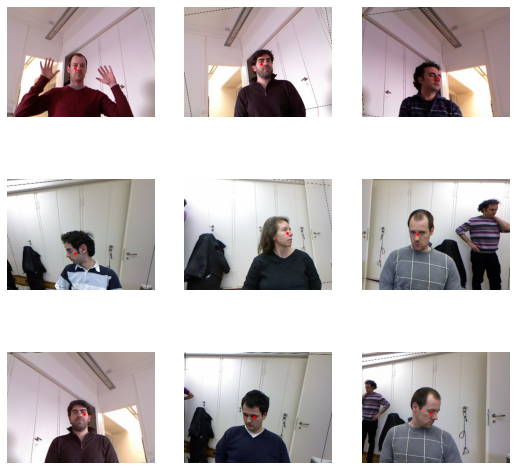

In [13]:
dls.show_batch()

**See. fast.ai can handle augmentations and points properly.**

Nice.

## Train the Model

Just like earlier. Let's use the cnn_learner

In [14]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.033113110810518265)

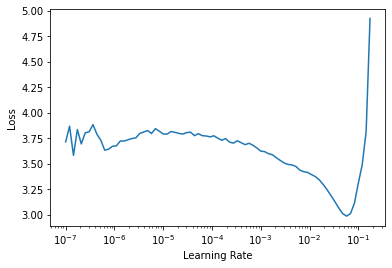

In [15]:
learn.lr_find()

In [16]:
learn.fine_tune(3, 1e-2)

epoch,train_loss,valid_loss,time
0,0.131303,0.034195,01:44


epoch,train_loss,valid_loss,time
0,0.026180,0.011280,01:47
1,0.005565,0.002694,01:48
2,0.001889,0.003327,01:49


In [17]:
learn.loss_func

FlattenedLoss of MSELoss()

Here we are using the mean squared error. So, here's the average difference between predicted and the real points.

In [18]:
math.sqrt(0.001735)

0.04165333119931706

This is super low with some minimal traning like this. Let's see how this looks like.

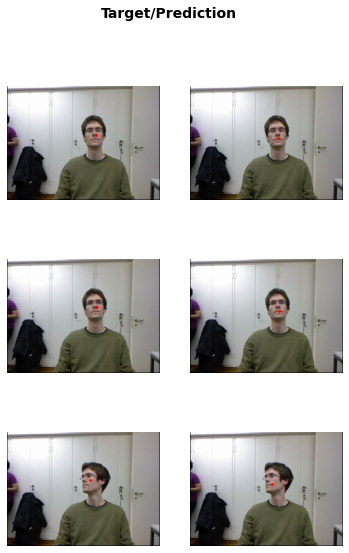

In [19]:
learn.show_results(ds_idx=1)

## Shall we do some predictions. Why not?


In [0]:
def predict(image):
  results = learn.predict(image)
  point = results[0][0]
  plt.imshow(image, zorder=1)
  plt.scatter(point[0], point[1], zorder=2)
  plt.show()

In [0]:
from ipywidgets import widgets

In [0]:
uploader = widgets.FileUpload()

In [32]:
uploader

FileUpload(value={'Screenshot 2020-05-26 at 12.34.01.png': {'metadata': {'lastModified': 1590476643927, 'type'…

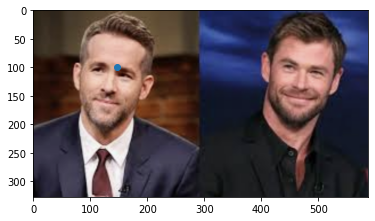

In [52]:
predict(PILImage.create(uploader.data[-1]))

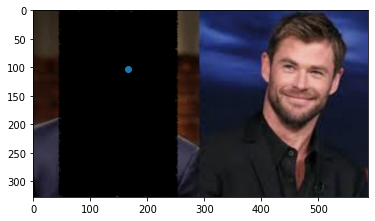

In [53]:
predict(PILImage.create(uploader.data[-1]))

It seems like our model is incorrect for other images. It always try to find the point on the same place.

Here's the same with the resized image. It doesn't work properly.

In [0]:
def predictResized(image):
  image = PILImage(image.resize((320, 240)))
  results = learn.predict(image)
  print(results)
  point = results[0][0]
  plt.imshow(image, zorder=1)
  plt.scatter(point[0], point[1], zorder=2)
  plt.show()

(TensorPoint([[165.6216, 103.5562]]), tensor([ 0.0351, -0.1370]), tensor([ 0.0351, -0.1370]))


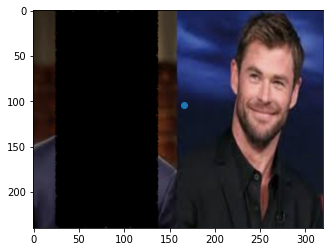

In [60]:
predictResized(PILImage.create(uploader.data[-1]))